In [6]:
import pandas as pd
import numpy as np
import rpy2.robjects as robjects
import rpy2.robjects as ro
from rpy2.robjects import pandas2ri
import time
import os
import csv
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

sns.set_style("white")

pandas2ri.activate()

In [7]:
data_file = "data/CHGdataSIMPA.txt"
basin_file = "data/CHGbasins.txt"
# data_file = "data/CHTdataSIMPAcal.txt"
# basin_file = "data/basinsSimpa.txt"

In [8]:
# Defining the R script and loading the instance in Python
r = robjects.r
r['source']('exec_optim_semidist.R')

# Loading the function we have defined in R.
robjects.globalenv['init_global'](data_file, basin_file)
exec_function_r = robjects.globalenv['eval_basin_param']
get_basin_q = robjects.globalenv['get_basin_q']

Rows: 5 Columns: 4
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
dbl (4): code, order, codedown, supha

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


In [9]:
# result_path = "results/new_data/"
problem_type = "full_qmm_5043"
result_path = ""
# problem_type = "full_eqw_3005"

result_files = [
    (f"./{result_path}config_{problem_type}_0_MSE.csv",0,"MSE"),
    (f"./{result_path}config_{problem_type}_1_MSE.csv",1,"MSE"),
    (f"./{result_path}config_{problem_type}_2_MSE.csv",2,"MSE"),
    (f"./{result_path}config_{problem_type}_3_MSE.csv",3,"MSE"),
    (f"./{result_path}config_{problem_type}_0_NSE.csv",0,"NSE"),
    (f"./{result_path}config_{problem_type}_1_NSE.csv",1,"NSE"),
    (f"./{result_path}config_{problem_type}_2_NSE.csv",2,"NSE"),
    (f"./{result_path}config_{problem_type}_3_NSE.csv",3,"NSE"),
    # (f"./{result_path}config_{problem_type}_0_R2.csv",0,"R2"),
    # (f"./{result_path}config_{problem_type}_1_R2.csv",1,"R2"),
    # (f"./{result_path}config_{problem_type}_2_R2.csv",2,"R2"),
    # (f"./{result_path}config_{problem_type}_3_R2.csv",3,"R2"),
    (f"./{result_path}config_{problem_type}_0_KGE.csv",0,"KGE"),
    (f"./{result_path}config_{problem_type}_1_KGE.csv",1,"KGE"),
    (f"./{result_path}config_{problem_type}_2_KGE.csv",2,"KGE"),
    (f"./{result_path}config_{problem_type}_3_KGE.csv",3,"KGE"),
]

for file_name, model, target in result_files:
    print(file_name, "Yes" if os.path.exists(file_name) else "No")

./config_full_qmm_5043_0_MSE.csv Yes
./config_full_qmm_5043_1_MSE.csv Yes
./config_full_qmm_5043_2_MSE.csv Yes
./config_full_qmm_5043_3_MSE.csv Yes
./config_full_qmm_5043_0_NSE.csv Yes
./config_full_qmm_5043_1_NSE.csv Yes
./config_full_qmm_5043_2_NSE.csv Yes
./config_full_qmm_5043_3_NSE.csv Yes
./config_full_qmm_5043_0_KGE.csv Yes
./config_full_qmm_5043_1_KGE.csv Yes
./config_full_qmm_5043_2_KGE.csv Yes
./config_full_qmm_5043_3_KGE.csv Yes


In [10]:
agg_q = {}
result_q = {}

basin_df = pd.read_csv(basin_file)
basin_df.sort_values(by=["order"])

eval_df = pd.DataFrame(columns=["model", "target", "basin_idx", "MSE", "RMSE", "Pbias", "NSE", "R2", "KGE", "params"])

for file_name, model, target in result_files:
    print(file_name, "Yes" if os.path.exists(file_name) else "No")
    if os.path.exists(file_name):
        params = np.loadtxt(file_name, delimiter=",", max_rows=1).reshape([len(basin_df),-1])

        prev_q = 0
        agg_q = {}
        basin_params = {}
        for idx in basin_df.index:
            basin_code = basin_df["code"][idx]
            codedown = basin_df["codedown"][idx]
            
            prev_q = 0
            if basin_code in agg_q:
                prev_q = agg_q[basin_code]
            
            if codedown not in agg_q:
                agg_q[codedown] = 0
            
            agg_q[codedown] += get_basin_q(model, params[idx], basin_code, prev_q)

            metrics = exec_function_r(model, params[idx], basin_code, prev_q)
            param_str = np.array2string(params[idx], max_line_width=np.inf, separator=";").replace(" ", "")
            eval_df.loc[len(eval_df)] = [model, target, basin_code] + list(metrics) + [param_str]

eval_df = eval_df[eval_df["target"] != "R2"]
eval_df    

./config_full_qmm_5043_0_MSE.csv Yes
./config_full_qmm_5043_1_MSE.csv Yes
./config_full_qmm_5043_2_MSE.csv Yes
./config_full_qmm_5043_3_MSE.csv Yes
./config_full_qmm_5043_0_NSE.csv Yes
./config_full_qmm_5043_1_NSE.csv Yes
./config_full_qmm_5043_2_NSE.csv Yes
./config_full_qmm_5043_3_NSE.csv Yes
./config_full_qmm_5043_0_KGE.csv Yes
./config_full_qmm_5043_1_KGE.csv Yes
./config_full_qmm_5043_2_KGE.csv Yes
./config_full_qmm_5043_3_KGE.csv Yes


,model,target,basin_idx,MSE,RMSE,Pbias,NSE,R2,KGE,params
0,0,MSE,5029,29.234445,5.406889,23.3,0.368690,0.422019,0.464286,[8.32941151e-01;1.97011823e+03;3.67806560e-01;...
1,0,MSE,5054,6.687501,2.586020,2238.7,-38.174384,0.160801,-21.455899,[5.47162726e-01;2.00000000e+03;7.41066450e-01;...
2,0,MSE,5060,2.609713,1.615461,22.0,0.541225,0.607949,0.685546,[9.83120056e-01;1.47523236e+03;8.68610436e-01;...
3,0,MSE,5071,20.754863,4.555751,-3.0,0.412698,0.423343,0.431033,[7.91919988e-01;2.00000000e+03;9.43679419e-01;...
4,0,MSE,5043,77.649461,8.811893,-1.9,0.567906,0.573243,0.699408,[9.97994188e-01;1.98305584e+03;9.47262618e-01;...
5,1,MSE,5029,24.925795,4.992574,8.3,0.461734,0.470331,0.516670,[8.45843978e-01;2.00000000e+03;1.14157335e-01;...
6,1,MSE,5054,3.342520,1.828256,1557.7,-18.579984,0.192812,-14.623573,[5.87553622e-01;1.79834568e+03;6.44234089e-01;...
7,1,MSE,5060,18.274796,4.274903,177.4,-2.212620,0.401096,-0.819602,[8.15046003e-01;1.95749956e+03;1.00000000e+00;...
8,1,MSE,5071,12.683791,3.561431,-11.4,0.641086,0.705950,0.565158,[8.50547423e-01;1.97095537e+03;9.96347080e-01;...
9,1,MSE,5043,79.301475,8.905138,-2.9,0.558713,0.564808,0.688949,[9.85734654e-01;1.99273454e+03;9.34709539e-01;...


In [11]:
eval_df[eval_df["target"] == "NSE"]

,model,target,basin_idx,MSE,RMSE,Pbias,NSE,R2,KGE,params
20,0,NSE,5029,21.773025,4.666157,4.5,0.529817,0.537781,0.669841,[9.05704545e-01;1.24878632e+03;0.00000000e+00;...
21,0,NSE,5054,0.182043,0.426665,-100.0,-0.066381,0.001335,-0.711215,[1.00000000e+00;1.86318398e+03;4.79150617e-01;...
22,0,NSE,5060,2.571581,1.603615,13.6,0.547929,0.568772,0.675677,[9.86234984e-01;1.66772575e+03;5.70171085e-01;...
23,0,NSE,5071,17.474802,4.180287,15.8,0.505514,0.537683,0.529587,[1.64240859e-01;1.42063482e+03;9.15871620e-01;...
24,0,NSE,5043,82.564687,9.086511,-5.1,0.540554,0.562744,0.716504,[9.94735016e-01;1.99721161e+03;9.93280077e-01;...
25,1,NSE,5029,22.508692,4.744333,-0.4,0.513931,0.516044,0.568085,[8.43199731e-01;1.52837136e+03;5.22844725e-01;...
26,1,NSE,5054,0.162043,0.402546,128.2,0.050775,0.184961,-0.580803,[5.19323461e-01;2.00000000e+03;9.18216777e-01;...
27,1,NSE,5060,1.716336,1.310090,6.9,0.698277,0.718089,0.673533,[9.30719254e-01;1.18950703e+03;5.36065935e-01;...
28,1,NSE,5071,9.927267,3.150757,-0.0,0.719087,0.751879,0.659060,[7.38434679e-01;1.99676242e+03;8.35635602e-01;...
29,1,NSE,5043,87.614180,9.360245,-4.6,0.512455,0.535653,0.697055,[9.20521449e-01;2.00000000e+03;9.37518707e-01;...


In [12]:
eval_df[eval_df["basin_idx"] == 5043]

,model,target,basin_idx,MSE,RMSE,Pbias,NSE,R2,KGE,params
4,0,MSE,5043,77.649461,8.811893,-1.9,0.567906,0.573243,0.699408,[9.97994188e-01;1.98305584e+03;9.47262618e-01;...
9,1,MSE,5043,79.301475,8.905138,-2.9,0.558713,0.564808,0.688949,[9.85734654e-01;1.99273454e+03;9.34709539e-01;...
14,2,MSE,5043,80.980571,8.998921,-5.4,0.549369,0.559753,0.678441,[9.91934065e-01;1.85530251e+03;9.27040695e-01;...
19,3,MSE,5043,82.229246,9.068034,-4.7,0.542421,0.553008,0.681377,[9.97874499e-01;1.99177276e+03;0.00000000e+00;...
24,0,NSE,5043,82.564687,9.086511,-5.1,0.540554,0.562744,0.716504,[9.94735016e-01;1.99721161e+03;9.93280077e-01;...
29,1,NSE,5043,87.614180,9.360245,-4.6,0.512455,0.535653,0.697055,[9.20521449e-01;2.00000000e+03;9.37518707e-01;...
34,2,NSE,5043,81.068994,9.003832,-3.5,0.548877,0.558626,0.693409,[9.55618441e-01;2.00000000e+03;8.30380823e-01;...
39,3,NSE,5043,83.222756,9.122651,-4.7,0.536892,0.556932,0.710244,[9.92450566e-01;1.91936713e+03;3.52172575e-01;...
44,0,KGE,5043,94.329212,9.712323,-0.1,0.475088,0.556380,0.744021,[9.88548456e-01;1.38196133e+03;9.99984512e-01;...
49,1,KGE,5043,103.236409,10.160532,-2.9,0.425523,0.523674,0.720085,[9.14575744e-01;1.76636365e+03;8.04332603e-01;...


In [13]:
eval_df.to_csv(f"{problem_type}_table.txt", index=False, quoting=csv.QUOTE_NONE)

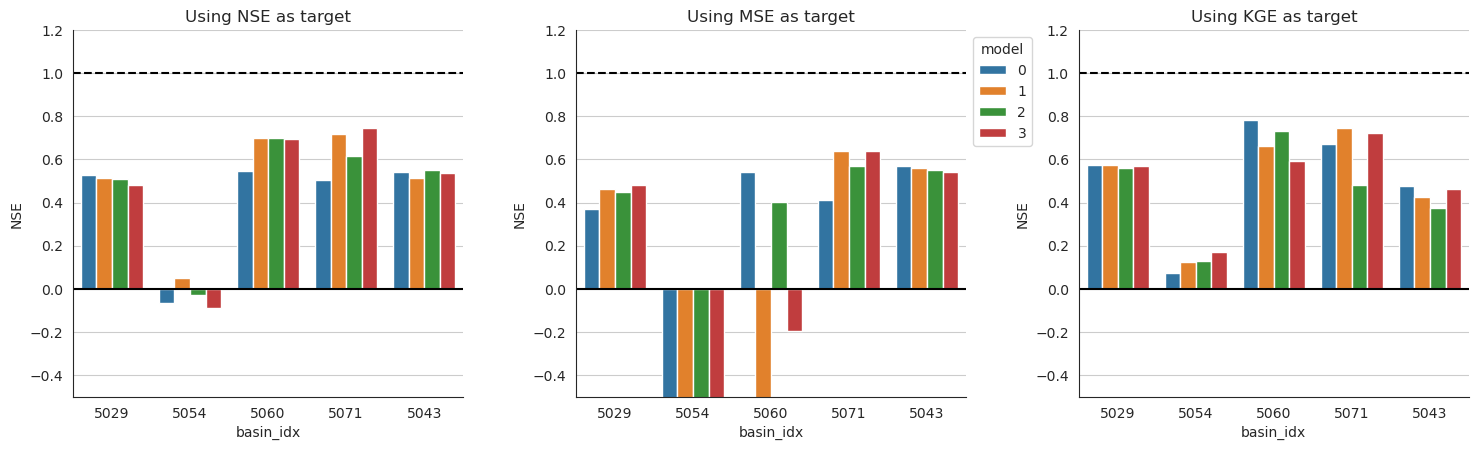

In [14]:
fig, axes = plt.subplots(1,3,figsize=(15, 5))


metric_measure = "NSE"
for idx, metric in enumerate(["NSE", "MSE", "KGE"]):    
    # ax = axes[idx//2, idx%2]
    ax = axes[idx]

    fig.tight_layout(h_pad=2)
    plt.subplots_adjust(top=0.85)

    data_to_plot = eval_df[eval_df["target"] == metric][['basin_idx', 'model', metric_measure]]
    hist_ax = sns.barplot(data=data_to_plot, x="basin_idx", y=metric_measure, hue="model", ax=ax, order=basin_df["code"])
    hist_ax.set(title = f"Using {metric} as target")


    if idx == 1:
        sns.move_legend(hist_ax, "upper left", bbox_to_anchor=(1, 1))
    else:
        hist_ax.get_legend().remove()
    

    if metric_measure not in ["MSE", "RMSE", "Pbias"]:
        ax.axhline(1, color="k", linestyle="--")
        if metric == "R2" and metric_measure in ["NSE", "KGE"]:
            hist_ax.set(ylim = [-0.5, 1.2])
            ax.axhline(0, color="k")
        else:
            hist_ax.set(ylim = [-0.5, 1.2])
            ax.axhline(0, color="k")
    

    if metric_measure == "Pbias":
        hist_ax.set(ylim = [-150, 750])#, yticks = range(-25,30,5))
        ax.axhline(0, color="k")
    
    sns.despine()
    ax.grid(axis="y")

plt.show()